# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Veronika Jirmusová
xjirmu00

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
import itertools
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [2]:
data = []

with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        if filename.endswith(".json"):
            with zf.open(filename, "r") as f:
                content = f.read().decode("utf-8")
                json_data = json.loads(content)
                data.append(json_data)  

df = pd.DataFrame(data)
df = df.astype({'run': int, 'runtime': float})

#Kontrola, ze je vse OK
display(df.head())
print(df.dtypes)  

,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS


configuration     object
run                int64
runtime          float64
status            object
dtype: object


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,200.0,123.104749,208.128584,0.000000,92.716828,99.799944,105.008525,1800.0
config2,200.0,167.456980,166.009023,0.000000,137.883249,151.576787,165.004250,1800.0
config3,200.0,144.151535,120.874132,0.000000,123.891821,138.038496,151.533715,1800.0
config4,200.0,143.054033,174.673555,0.000000,93.049865,129.975246,165.023842,1800.0
config5,200.0,198.904871,164.334180,0.000000,163.910896,183.916111,201.549486,1800.0
config6,200.0,118.870575,126.237033,2.124534,81.741231,111.088189,137.889290,1800.0




Identified outliers:


,configuration,run,runtime,status,outlier
6,config5,103,1800.000000,TIME LIMIT,True
42,config3,41,0.000000,SEGFAULT,True
51,config1,62,0.000000,SEGFAULT,True
92,config2,142,0.000000,SEGFAULT,True
99,config1,134,1800.000000,TIME LIMIT,True
104,config2,40,1800.000000,TIME LIMIT,True
230,config5,118,0.000000,SEGFAULT,True
301,config3,78,201.577616,SUCCESS,True
318,config3,184,0.000000,SEGFAULT,True
327,config4,110,1800.000000,TIME LIMIT,True


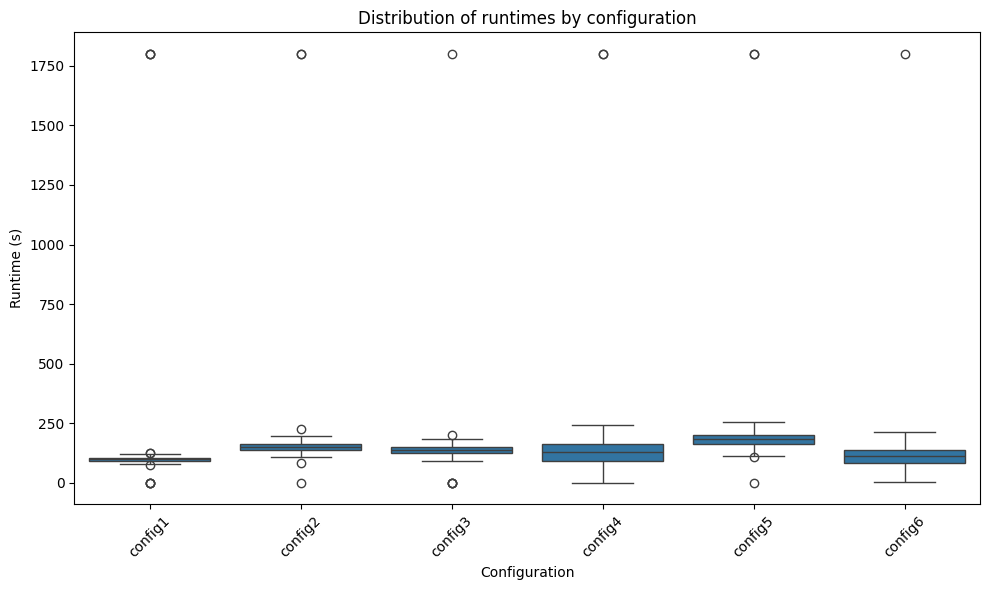

In [3]:
config_stats = df.groupby('configuration')['runtime'].describe()
display(config_stats)
print("\n")

# Detekce vychylenych hodnot
def detect_outliers(data):
    q_1 = data.quantile(0.25)  
    q_3 = data.quantile(0.75)  # Prvni a treti kvartil
    iqr = q_3 - q_1 
    
    low = q_1 - 1.5 * iqr 
    upp = q_3 + 1.5 * iqr 

    return (data < low) | (data > upp)

df['outlier'] = df.groupby('configuration')['runtime'].transform(detect_outliers)

# Vychylene hodnoty
outliers = df[df['outlier']]
print("Identified outliers:")
display(outliers)

# Boxplot
config_order = ['config1', 'config2', 'config3', 'config4', 'config5', 'config6']
plt.figure(figsize=(10, 6))
sns.boxplot(x='configuration', y='runtime', data=df, order=config_order)
plt.title('Distribution of runtimes by configuration')
plt.ylabel('Runtime (s)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

Jak lze vidět výše, tak ano, chybné hodnoty (a outliers) se v databázi objevily. Jedná se o běhy, které neskončily úspěchem anebo o běhy, které mají až příliš vychýlenou hodnotu od průměrného běhu. Chyby mohou být různorodé, ale nejčastější chyba je chyba v implementaci algoritmu a v jeho nesprávném zacházení s přístupy do paměti - viz chyba segfault. Dále lze vidět, že se v některých případech algoritmus zacyklí nebo obsahuje jiné chyby, tedy nastane timeout, předčasné ukončení programu nebo vychýlené časové běhy. Jistě takové chyby mohly vzniknout i náhodně, tedy třeba vysokým zatížením systému nebo dostupností paměti, atd. 

Tento druh grafu jsem zvolila díky jeho vysoké přehlednosti při zobrazování vzájemných vztahů mezi chybnými hodnotami a zbytkem dat a poměrně jasně a zřetelně umí zobrazit data, která chceme mezi sebou porovnávat. Dále o něm velmi výrazně mluvil pan doktor na democvičení, takže jsem s ním byla nejvíce obeznámena a lépe se mi tedy i tvoří.


Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

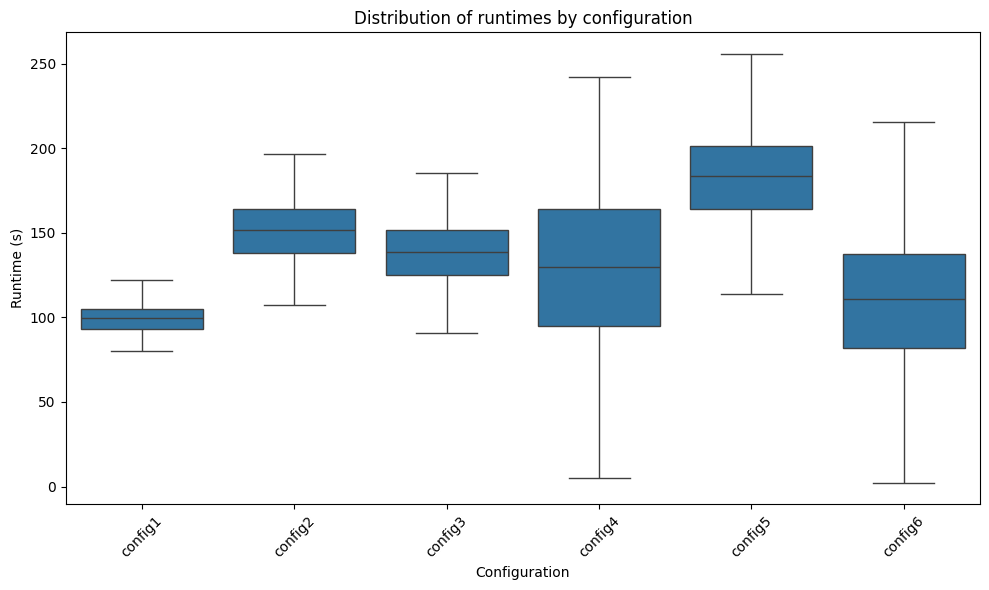

In [4]:
# Tady kopiruji svuj vlastni kod z predchoziho cviceni a jen upravuji vysledky
config_order = ['config1', 'config2', 'config3', 'config4', 'config5', 'config6']
success = df[df['status'] == "SUCCESS"]
plt.figure(figsize=(10, 6))
sns.boxplot(x='configuration', y='runtime', data=success, order=config_order, showfliers=False)
plt.title('Distribution of runtimes by configuration')
plt.ylabel('Runtime (s)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
config_stats = success.groupby('configuration')['runtime'].describe()

display(config_stats)


,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,193.0,99.590413,9.386788,73.802549,92.979469,99.865028,104.824724,127.201692
config2,197.0,151.732975,19.833198,85.174653,137.995662,151.516091,163.802880,227.054630
config3,195.0,138.616959,19.867428,90.567110,124.803901,138.678404,151.536291,201.577616
config4,196.0,127.606156,50.282164,4.970286,94.793688,129.975246,164.327163,241.987620
config5,197.0,183.659767,28.729836,107.283620,164.070091,183.843132,201.250693,255.807973
config6,199.0,110.422689,40.875754,2.124534,81.656211,111.043642,137.554141,215.295283


__OTÁZKA K DOPLNĚNÍ:__

Z parametrů lze vyčíst: 
count - počet hodnot, 
mean - průměr,
std - standardní odchylka,
min - minimum,
25% - 1. kvartil,
50% - medián,
75% - 3. kvartil,
max - maximum.

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

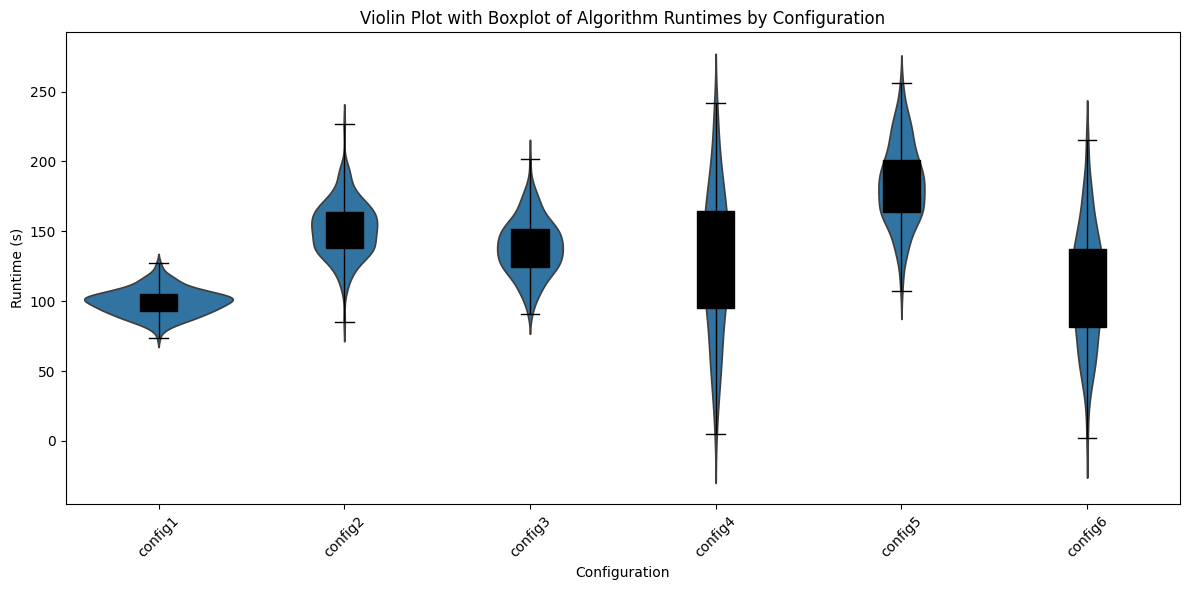

In [6]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='configuration', y='runtime', data=success, order=['config1', 'config2', 'config3', 'config4', 'config5', 'config6'], inner=None)
sns.boxplot(x='configuration', y='runtime', data=success, order=['config1', 'config2', 'config3', 'config4', 'config5', 'config6'], 
            whis=np.inf, color='k', width=0.2, fliersize=0) 
plt.title('Violin Plot with Boxplot of Algorithm Runtimes by Configuration')
plt.ylabel('Runtime (s)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._


Lze pozorovat, že konfigurace 1 má nejvíce konzistentní časy běhů programu narozdíl třeba od konfigurace 4. Z grafu není možné 100% vyčíst, která konfigurace je nejefektivnější. Kombinací boxplotu a violin plotu jsem chtěla naznačit rozptyl jednotlivých hodnot běhů a jejich vzájemných odchylek.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Zkoumaná data jsou jednotlivé běhy konfigurací, přičemž porovnávám každé dvě konfigurace spolu navzájem a očekávám, že se rozdíly mezi běhy projeví jak v průměrné době běhu, tak ve variabilitě. Pomocí Shapiro-Wilk testu jsem zjistila, že všechny konfigurace mají normální rozdělení (tedy nelze vyloučit, že ho nemají), je tedy možné provést Studentův nepárový t-test pro zjištění závislosti dat. Mezi parametry patří střední doba a rozptyl - tedy jak se běhy liší od průměru. Nulová hypotéza je tedy že obě konfigurace, které porovnáváme, mají stejný průměr. Alternativní hypotéza pak může být, že se tyto doby liší. Variabilita ukazuje, jak se jednotlivé hodnoty běhu liší od průměrné hodnoty běhu, poloha pak odkazuje na střední hodnotu, tedy u každé konfigurace lze pozorovat jiný rozdíl těchto hodnot - sice 4. konfigurace má vysokou variabilitu, ale ve skutečnosti není spolehlivě rychlejší.

Shapiro-Wilk test for config1: Stats = 0.9954743765602111, p-value = 0.8348061354960175
Shapiro-Wilk test for config2: Stats = 0.9912934241679304, p-value = 0.28399685772741945
Shapiro-Wilk test for config3: Stats = 0.9965779279919601, p-value = 0.9447037576209982
Shapiro-Wilk test for config4: Stats = 0.9931968160110766, p-value = 0.5025231305724767
Shapiro-Wilk test for config5: Stats = 0.9938172043616607, p-value = 0.5855018828871443
Shapiro-Wilk test for config6: Stats = 0.9950868815162213, p-value = 0.7656591016111406


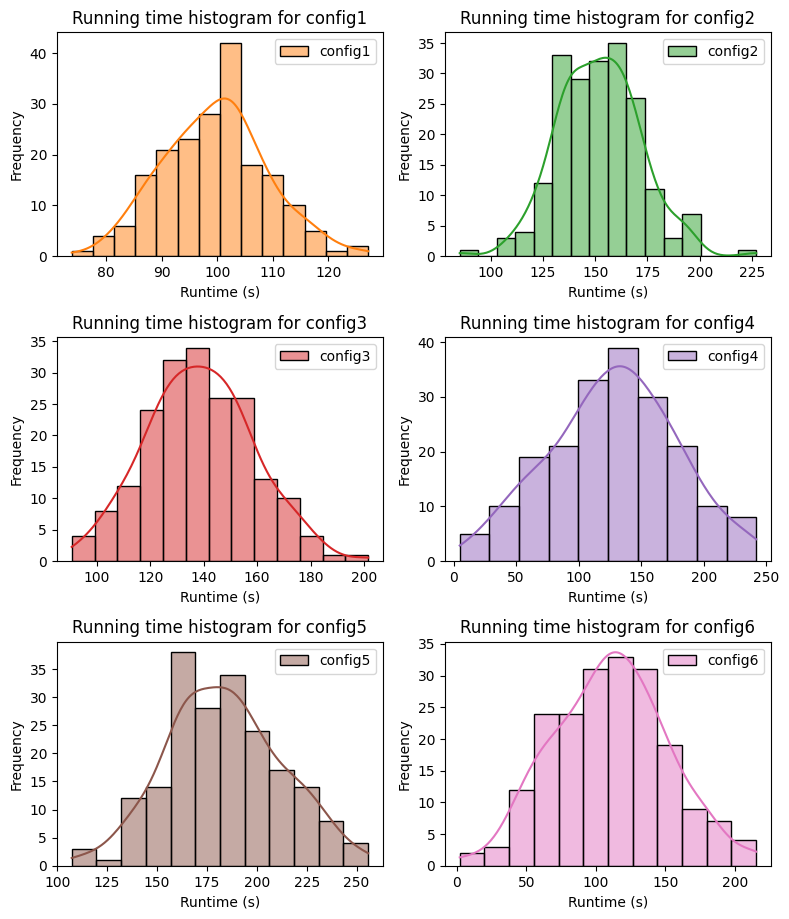


Shapiro-Wilk test results for all configurations:
  Configuration     Stats   p-value
0       config1  0.995474  0.834806
1       config2  0.991293  0.283997
2       config3  0.996578  0.944704
3       config4  0.993197  0.502523
4       config5  0.993817  0.585502
5       config6  0.995087  0.765659

T-test results:


,Configuration 1,Configuration 2,t-stats,p-value
0,config1,config2,-33.290469,1.691962e-99
1,config1,config3,-24.778306,2.979765e-72
2,config1,config4,-7.665912,6.604315e-13
3,config1,config5,-39.001316,2.135159e-105
4,config1,config6,-3.640683,3.391848e-04
5,config2,config3,6.540935,1.922497e-10
6,config2,config4,6.251185,1.711557e-09
7,config2,config5,-12.835992,3.807611e-31
8,config2,config6,12.814184,4.938593e-30
9,config3,config4,2.850241,4.726144e-03


Mean runtime for every configuration:


,Configuration,Mean Runtime
0,config1,99.590413
1,config6,110.422689
2,config4,127.606156
3,config3,138.616959
4,config2,151.732975
5,config5,183.659767



Fastest configuration is config1 with mean runtime 99.59041343897528 seconds.


In [7]:
plt.figure(figsize=(8, len(config_order) * 3))
shapiro = []

for i, config in enumerate(config_order, 1):
    # Filtrace
    config_data = success[success['configuration'] == config]['runtime']
    # Podgrafy
    plt.subplot(len(config_order), 2, i)
    sns.histplot(config_data, kde=True, label=f'{config}', color=f'C{i}')
    plt.title(f'Running time histogram for {config}')
    plt.xlabel('Runtime (s)')
    plt.ylabel('Frequency')
    plt.legend()

    stat, p_value = stats.shapiro(config_data)
    shapiro.append((config, stat, p_value))

    print(f"Shapiro-Wilk test for {config}: Stats = {stat}, p-value = {p_value}")

plt.tight_layout()
plt.show()

# Vysledek Shapiro-Wilk testu
shapiro_df = pd.DataFrame(shapiro, columns=['Configuration', 'Stats', 'p-value'])
print("\nShapiro-Wilk test results for all configurations:")
print(shapiro_df)


ttest = []
# Tady mozna bude problem s itertools, ale je to nejlepsi zpusob, jak udelat kombinace vsech moznych dvojic
pairs = list(itertools.combinations(config_order, 2))
# Vsechny kombinace dvojic
for config1, config2 in pairs:
    d1 = success[success['configuration'] == config1]['runtime']
    d2 = success[success['configuration'] == config2]['runtime']
    
    t_stat, p_value = stats.ttest_ind(d1, d2, equal_var=False)
    
    ttest.append({
        'Configuration 1': config1,
        'Configuration 2': config2,
        't-stats': t_stat,
        'p-value': p_value
    })

ttest_df = pd.DataFrame(ttest)

print("\nT-test results:")
display(ttest_df)

# Prumerne doby behu
mean_runtimes = success.groupby('configuration')['runtime'].mean().sort_values()
mean_runtimes_df = pd.DataFrame(mean_runtimes).reset_index()
mean_runtimes_df.columns = ['Configuration', 'Mean Runtime']

print("Mean runtime for every configuration:")
display(mean_runtimes_df)
# Nejrychlejsi doba behu
fastest = mean_runtimes.idxmin()
print(f"\nFastest configuration is {fastest} with mean runtime {mean_runtimes.min()} seconds.")


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

Konfigurace 1 je spolehlivě nejrychlejší ze všech konfigurací a konfigurace 5 je nejpomalejší. P-hodnoty všech t-testů jsou uvedeny ve výstupu kódu, tedy pokud je p-hodnota < 0.05, zamítáme nulovou hypotézu, jinak nemáme dostatek dat pro její zamítnutí.

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [25]:
# Variance, protoze nemuzu spravne pouzit np.var
def variance_f(data):
    mean = np.mean(data)
    n = len(data)
    variance = sum((x - mean) ** 2 for x in data) / (n - 1)
    return variance

# Predpokladam, ze Shapiro-Wilk implementovat nemusim (doufam), takze muj t-test (protoze jsou data v normalnim rozlozeni)
def my_ttest(conf1, conf2):
    # Pocet pozorovani
    x1 = len(conf1)
    x2 = len(conf2)
    
    # Prumer behu pro kazdou konfiguraci
    mean1 = np.mean(conf1)
    mean2 = np.mean(conf2)
    
    # Smerodatna odchylka
    y1 = variance_f(conf1)
    y2 = variance_f(conf2)
    
    # T-statistika
    t_stats = (mean1 - mean2) / (((y1 / x1) + (y2 / x2))**0.5)
    
    # Stupne volnosti
    dof = (y1 / x1 + y2 / x2) ** 2 / ((y1 / x1) ** 2 / (x1 - 1) + (y2 / x2) ** 2 / (x2 - 1))
    
    return t_stats, dof

configs = success['configuration'].unique()

# Slovnik pro lepsi pristup k hodnotam
dictionary = success.groupby('configuration')['runtime'].apply(np.array).to_dict()  
res = []

# Vsechny kombinace dvojic
for i in range(len(configs)):
    for j in range(i + 1, len(configs)):
        config1 = configs[i]
        config2 = configs[j]
        
        data1 = dictionary[config1]
        data2 = dictionary[config2]
        
        # Muj t-test
        t_stats_custom, dof_custom = my_ttest(data1, data2)

        # Pro ukazku na porovnani scipy t-test
        t_stats_scipy, p_value_scipy = stats.ttest_ind(data1, data2, equal_var=False)
        
        # P-hodnoty a stupne volnosti uz nevypisuji, prijde mi to redundantni (v kodu jsou pro pripadnou dalsi praci s daty)
        res.append({
            'Configuration 1': config1,
            'Configuration 2': config2,
            'Custom t-statistic': t_stats_custom,
            'SciPy t-statistic': t_stats_scipy
            })
        
res_df = pd.DataFrame(res)
print("T-test results for all configuration pairs:")
display(res_df)

sorted_mr_df = success.groupby('configuration')['runtime'].mean().sort_values().reset_index()
sorted_mr_df.columns = ['Configuration', 'Mean Runtime']

fastest_c, fastest_t = sorted_mr_df.iloc[0]

print("Mean runtime for every configuration:")
display(sorted_mr_df)
print(f"Fastest Configuration: {fastest_c} with a mean runtime of {fastest_t}")

T-test results for all configuration pairs:


,Configuration 1,Configuration 2,Custom t-statistic,SciPy t-statistic
0,config6,config2,-12.814184,-12.814184
1,config6,config4,-3.723625,-3.723625
2,config6,config5,-20.643696,-20.643696
3,config6,config3,-8.734154,-8.734154
4,config6,config1,3.640683,3.640683
5,config2,config4,6.251185,6.251185
6,config2,config5,-12.835992,-12.835992
7,config2,config3,6.540935,6.540935
8,config2,config1,33.290469,33.290469
9,config4,config5,-13.559417,-13.559417


Mean runtime for every configuration:


,Configuration,Mean Runtime
0,config1,99.590413
1,config6,110.422689
2,config4,127.606156
3,config3,138.616959
4,config2,151.732975
5,config5,183.659767


Fastest Configuration: config1 with a mean runtime of 99.59041343897528
